# Classification of Inappropriate/Offensive Text

## Import the essentials

In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist
nltk.download('stopwords')
nltk.download('punkt')

# Load the dataset
data = pd.read_csv('dataset.csv')
data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\batuh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\batuh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,Gerçekten sizin hikayelerinizi izleyerek mi ye...,0
1,@USER Çoook çok bi baklava bi sen zaten,0
2,"1) Sn. DÜKEL; Atatürk'ün, Karma E. M. ile başl...",0
3,Konfederasyonumuzun Aile ve Sosyal Politikalar...,0
4,Hakemler tarih yazıyorlar / 9 kişiye karşı 3-2...,1


## Data Preprocessing Part

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53005 entries, 0 to 53004
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    53005 non-null  object
 1   label   53005 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 828.3+ KB


In [3]:
# Function to remove unnecessary user tags from the entries
def clean_text(text):
    text = text.replace("@USER ", "")
    text = text.replace("@USER", "")
    return text

# Apply the cleaning function to the 'text' column
data['text'] = data['text'].apply(clean_text)

# Remove emojis from the samples
data.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

# Save the cleaned dataframe
data.to_csv('cleaned_dataset.csv', index=False)

## Exploratory Data Analysis Results
The dataset includes 53005 rows and is about to offensive text. We can clearly see that our data has 2 columns which are not null: *text* and *label*. So we don't need to clear or fill the null values.

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
label,53005.0,0.463692,0.498685,0.0,0.0,0.0,1.0,1.0


### Most used words

In [5]:
def find_most_common(data, number = 50):
  words_filter = ['@', '.', 'USER', ',', '#', 've', 'bir', 'bu', 'Bu', 'de', 'ne', '!' ':', 'https', '"', '...', '``']
  text_list = data['text'].tolist()

  # Join all the strings in the list into a single string
  text = ' '.join(text_list)

  # Tokenize the text into words
  words = nltk.word_tokenize(text)
  # Count the frequency of each word
  freq_dist = FreqDist(words)
  stopwords = nltk.corpus.stopwords.words('turkish')
  dict_filter = lambda freq_dist, stopwords: dict( (word,freq_dist[word]) for word in freq_dist if (word not in stopwords and word not in words_filter and len(word) > 1) )
  filtered_freq_dist = dict_filter(freq_dist, stopwords)

  print(type(filtered_freq_dist))
  # Get the most frequent words
  most_frequent_words = FreqDist(filtered_freq_dist).most_common(number)
  return most_frequent_words

In [6]:
# Filter the symbols and most common adjuncts in Turkish
# Convert the text column to a list of strings
data_offensive = data[data['label'] == 1]
data_not_offensive = data[data['label'] == 0]

most_frequent_words_in_offensive = find_most_common(data_offensive)
most_frequent_words_not_in_offensive = find_most_common(data_not_offensive)

<class 'dict'>
<class 'dict'>


In [8]:
# Extract the words and frequencies from the most_frequent_words list
words, frequencies = zip(*most_frequent_words_in_offensive)

# Create a bar chart of the most frequent words
plt.figure(figsize=(15,6))
plt.bar(words, frequencies)
plt.xlabel("Words")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Frequency")
plt.title("Most Frequent Words in the Offensive Sentences")
plt.show()

NameError: name 'plt' is not defined

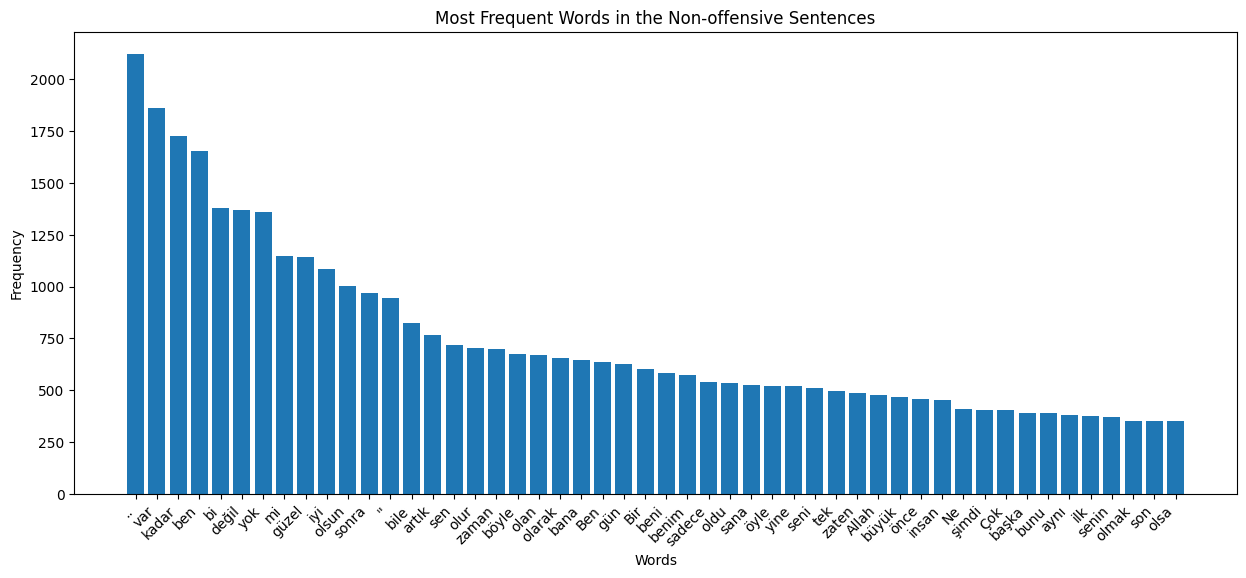

In [12]:
# Extract the words and frequencies from the most_frequent_words list
words, frequencies = zip(*most_frequent_words_not_in_offensive)

# Create a bar chart of the most frequent words
plt.figure(figsize=(15,6))
plt.bar(words, frequencies)
plt.xlabel("Words")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Frequency")
plt.title("Most Frequent Words in the Non-offensive Sentences")
plt.show()

In [13]:
print(type(freq_dist))
print(type(most_frequent_words))
print(most_frequent_words)
print(len('#'))

NameError: name 'freq_dist' is not defined

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

data2 = pd.read_csv('cleaned_dataset.csv')
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data2['text'])

feature_names = vectorizer.get_feature_names_out()

X_array = X.astype(bool).toarray()

X_train, X_test, y_train, y_test = train_test_split(X_array, data2['label'].astype(bool), test_size=0.2)





print("Unique Word List: \n", feature_names)
print("Bag of Words Matrix: \n", X_array)


Unique Word List: 
 ['00' '000' '0000' ... '지민_열아홉살때부터_봤잖아요' '지민은_천사가_남긴_기적' '𝟮𝟮𝟬𝟳𝟭𝟵']
Bag of Words Matrix: 
 [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier_dt.fit(X_train, y_train)

#Decision Tree
y_pred_dt = classifier_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred_dt)
print(cm)

dt_score = accuracy_score(y_test, y_pred_dt)
print('Decision Tree Accuracy: ', str(dt_score))